In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

from models import CBM, TaskType
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

2016-07-01 00:00:00
2018-06-26 19:00:00


<Axes: xlabel='date'>

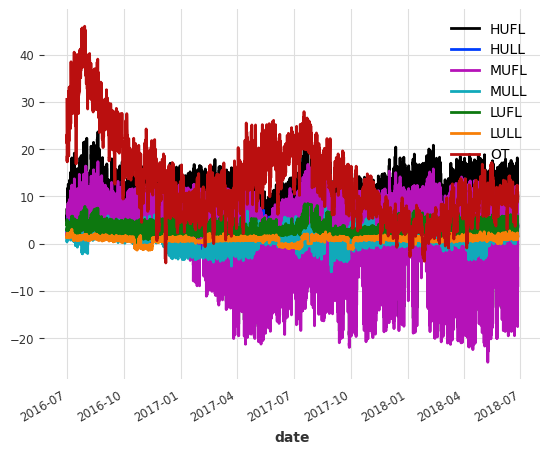

In [2]:
series = ETTh1Dataset().load()

print(series.start_time())
print(series.end_time())

series.plot()

In [3]:
train_series, test_series = series.split_before(0.6)
val_series, test_series = test_series.split_before(0.5)


In [4]:
batch_size = 32
learning_rate = 0.005
epochs = 10
seq_len = 336
pred_len = 96


In [5]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [6]:
lr_lambda = lambda epoch: 0.5 ** ((epoch - 1) // 1)
lr_scheduler_kwargs = {"lr_lambda": lr_lambda}

In [7]:
model_not_shared = NLinearModel(
    input_chunk_length=seq_len,
    output_chunk_length=pred_len,
    n_epochs=epochs,
    #shared_weights=True
    pl_trainer_kwargs=pl_trainer_kwargs,
    optimizer_cls = torch.optim.Adam,
    optimizer_kwargs={'lr': learning_rate},
    lr_scheduler_cls = LambdaLR,
    lr_scheduler_kwargs = lr_scheduler_kwargs,
)

model_not_shared.fit(series=train_series["OT"], past_covariates=train_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]],
          val_series=val_series["OT"], val_past_covariates=val_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]], 
          )


# pred = model.predict(96)
# pred = model.predict(96, series=val_series["OT"], past_covariates=val_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:43: attribute 'lr_scheduler_kwargs' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 225 K 
---------------------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.904     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=336, output_chunk_length=96, n_epochs=10, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f48364234f0>]}, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.005}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.LambdaLR'>, lr_scheduler_kwargs={'lr_lambda': <function <lambda> at 0x7f4835485090>})

In [8]:
maes = 0
mses = 0
steps = test_series.n_timesteps - pred_len - seq_len

for i in range(steps):
    pred = model_not_shared.predict(pred_len, series=test_series["OT"][i:i+seq_len], past_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][i:i+seq_len], verbose=False)
    maes += mae(test_series["OT"], pred, intersect=True)
    mses += mse(test_series["OT"], pred, intersect=True)


maes /= steps
print("MAE", maes)
mses /= steps
print("MSE", mses)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

MAE 2.5868565062840987
MSE 10.506572004586006


In [9]:
model_shared = NLinearModel(
    input_chunk_length=seq_len,
    output_chunk_length=pred_len,
    n_epochs=epochs,
    shared_weights=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
    optimizer_cls = torch.optim.Adam,
    optimizer_kwargs={'lr': learning_rate},
    lr_scheduler_cls = torch.optim.lr_scheduler.LambdaLR,
    lr_scheduler_kwargs = lr_scheduler_kwargs,
)

model_shared.fit(series=train_series, val_series=val_series)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:43: attribute 'lr_scheduler_kwargs' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 32.4 K
---------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.129     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NLinearModel(shared_weights=True, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=336, output_chunk_length=96, n_epochs=10, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f482f036ec0>]}, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.005}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.LambdaLR'>, lr_scheduler_kwargs={'lr_lambda': <function <lambda> at 0x7f4835485090>})

In [10]:
maes = 0
mses = 0
steps = test_series.n_timesteps - pred_len - seq_len

for i in range(steps):
    pred = model_shared.predict(pred_len, series=test_series[i:i+seq_len], verbose=False)
    maes += mae(test_series["OT"], pred["OT"], intersect=True)
    mses += mse(test_series["OT"], pred["OT"], intersect=True)

maes /= steps
print("MAE", maes)
mses /= steps
print("MSE", mses)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

MAE 2.348573984464358
MSE 8.794318658396717


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

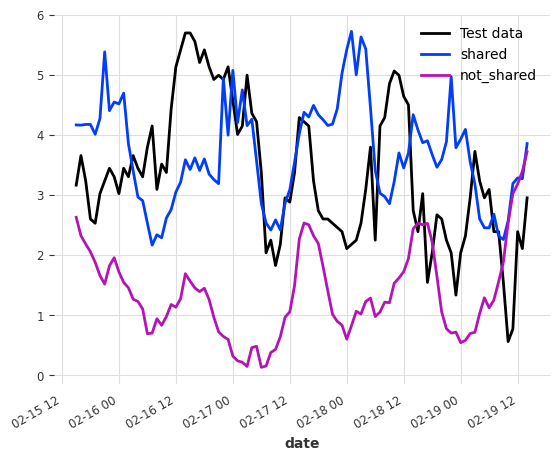

In [23]:
shared = model_shared.predict(pred_len, series=test_series[:seq_len])["OT"]
not_shared = model_not_shared.predict(pred_len, series=test_series["OT"][:seq_len], past_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][:seq_len])

# Plot the predictions
# train_series["OT"][-100:].plot(label='Training data')
# val_series["OT"][-96:].plot(label='Validation data')
test_series["OT"][seq_len:seq_len+pred_len].plot(label='Test data')
shared.plot(label='shared')
not_shared.plot(label='not_shared')
